In [3]:
import os
import sys
sys.path.append(os.path.abspath('../'))

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import neural_lam.utils as utils
from neural_lam.constants import ERA5UKConstants

In [4]:
full_dataset_size = 12 * 12 * 28
full_dataset_size

4032

# Utils

In [174]:
def rollout_axs(
    ax, 
    var_name,
    rmses,
    labels,
):
    var_idx = ERA5UKConstants.PARAM_NAMES.index(var_name)
    var_unit = ERA5UKConstants.PARAM_UNITS[var_idx]
    
    for i, rmse in enumerate(rmses):
        ax.plot(rmse[var_idx], ".-", label=labels[i])

    if var_name in ERA5UKConstants.CLIMATOLOGY:
        var_clim = ERA5UKConstants.CLIMATOLOGY[var_name]
        ax.axhline(var_clim, color="grey", linestyle="--", label="Climatology")

    xticks_pos = range(0, rmses[0].shape[1], 2)
    xticks_labels = [str((tick + 1) * 6) for tick in xticks_pos]
    ax.set_xticks(xticks_pos)
    ax.set_xticklabels(xticks_labels)

    ax.legend()
    ax.set_xlabel("Lead Time (hours)")
    ax.set_ylabel(f"RMSE ({var_unit})")
    ax.set_title(f"Test RMSE: {var_name}")
    ax.grid(True)
    
def load_single_level_rmse(path, length=8):
    # eval on entire uk
    csv_path = f".{path}/files/test_rmse.csv"
    rmse = np.loadtxt(csv_path, delimiter=',').T
    if length is None:
        return rmse
    rmse = rmse[:, :length]
    # print(rmse.shape)
    return rmse

def load_space_attention_rmse(path, length=8):
    level_1_rmse_path = f".{path}/files/level-1_test_rmse.csv"
    level_1_rmse = np.loadtxt(level_1_rmse_path, delimiter=",").T
    # print(level_1_rmse.shape)p
    level_1_rmse = level_1_rmse[:, :length]

    level_0_rmse_path = f".{path}/files/level-0_test_rmse.csv"
    level_0_rmse = np.loadtxt(level_0_rmse_path, delimiter=",").T
    # print(level_0_rmse.shape)
    level_0_rmse = level_0_rmse[:, :length]
    
    return level_0_rmse, level_1_rmse

def score(a, b):
    count = np.sum(a > b) / (a.shape[0] * a.shape[1])
    pct_diff = np.mean((a - b) / b)
    print(count, pct_diff)

In [3]:
# import torch

# param_means = torch.load("../data/era5_uk_big/static/parameter_mean.pt")
# param_stds = torch.load("../data/era5_uk_big/static/parameter_std.pt")

# Baseline Results

In [175]:
gcn_big_rmse = load_single_level_rmse("./wandb/offline-run-20240613_114156-ifbz5py9")
gat_big_rmse = load_single_level_rmse("./wandb/offline-run-20240613_212401-4e7u3cx3")
gc_big_rmse = load_single_level_rmse("./wandb/offline-run-20240607_233313-15gl53gn")
gc_big_2_years_rmse = load_single_level_rmse("./wandb/offline-run-20240614_084440-2rsx0e6t")

gcn_big_rmse = gcn_big_rmse[:, :8]
gat_big_rmse = gat_big_rmse[:, :8]
gc_big_rmse = gc_big_rmse[:, :8]
gc_big_2_years_rmse = gc_big_2_years_rmse[:, :8]

score(gcn_big_rmse, gc_big_rmse)
score(gat_big_rmse, gc_big_rmse)
score(gc_big_2_years_rmse, gc_big_rmse)
score(gcn_big_rmse, gat_big_rmse)

0.7864583333333334 0.07009329152237469
0.7734375 0.038922165756426465
0.13802083333333334 -0.0685065649053922
0.7161458333333334 0.030270562342398884


In [90]:
np.mean(gcn_big_rmse), np.mean(gat_big_rmse), np.mean(gc_big_rmse)

(121.98530114021611, 116.65084041178558, 113.89590828451396)

In [93]:
pd.dataframe()

AttributeError: module 'pandas' has no attribute 'dataframe'

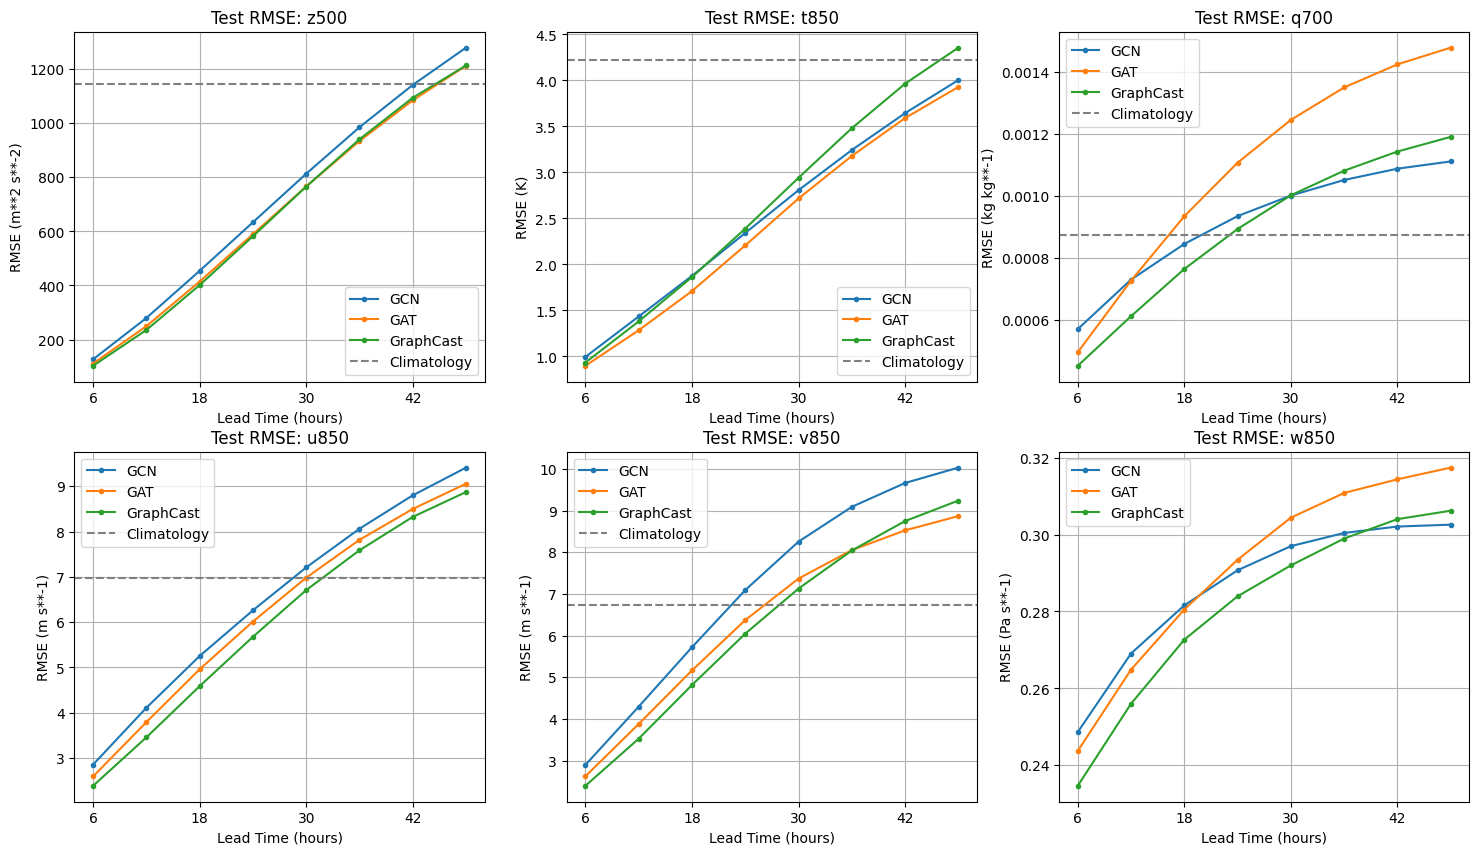

In [153]:
rmses = [
    gcn_big_rmse, 
    gat_big_rmse,
    gc_big_rmse
]
labels = [
    "GCN",
    "GAT",
    "GraphCast"
]


headline_vars = ["z500", "t850", "q700", "u850", "v850", "w850"]

fig, axs = plt.subplots(2, 3, figsize=(18, 10))
for ax, var_name in zip(axs.flat, headline_vars):
    rollout_axs(
        ax, 
        var_name,
        rmses=rmses,
        labels=labels
    )

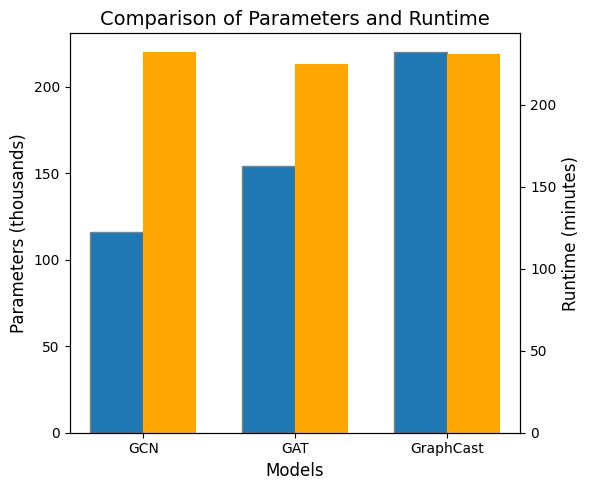

In [176]:
import matplotlib.pyplot as plt
import numpy as np

# Data
columns = ["GCN", "GAT", "GraphCast"]
parameters = [116, 154, 220]
runtime = [232, 225, 231]

# Number of bars
N = len(columns)

# Set the bar width
bar_width = 0.35

# Set the positions of the bars on the X-axis
r1 = np.arange(N)
r2 = [x + bar_width for x in r1]

# Create the plot
fig, ax1 = plt.subplots(figsize=(6, 5))

# Create a second y-axis
ax2 = ax1.twinx()

# Plotting the bars
bars1 = ax1.bar(r1, parameters, width=bar_width, edgecolor='grey', label='Parameters (thousands)')
bars2 = ax2.bar(r2, runtime, width=bar_width, color="orange", label='Runtime (minutes)')

# Adding labels, title, and legend
ax1.set_xlabel('Models', fontsize=12)
ax1.set_ylabel('Parameters (thousands)', fontsize=12)
ax2.set_ylabel('Runtime (minutes)', fontsize=12)
ax1.set_title('Comparison of Parameters and Runtime', fontsize=14)
ax1.set_xticks([r + bar_width / 2 for r in range(N)])
ax1.set_xticklabels(columns, fontsize=10)

# # Adding legends
# l1 = ax1.legend([bars1], ['Parameters'], loc='upper right')
# l2 = ax2.legend([bars2], ['Runtime'], loc='upper right')

# l1.set_zorder(100)
# l2.set_zorder(100)

# Display the plot
fig.tight_layout()
plt.show()


# Time Resolution Analysis

In [138]:
step_1_rmse = load_single_level_rmse("./wandb/offline-run-20240607_233313-15gl53gn", None)
step_2_rmse = load_single_level_rmse("./wandb/offline-run-20240612_214019-25opcqan", None)
step_4_rmse = load_single_level_rmse("./wandb/offline-run-20240612_214432-qocjcog7", None)

step_1_rmse = step_1_rmse[:, :12]
step_2_rmse = step_2_rmse[:, :6]
step_4_rmse = step_4_rmse[:, :3]

print(step_1_rmse.shape, step_2_rmse.shape, step_4_rmse.shape)

(48, 12) (48, 6) (48, 3)


In [126]:
step_1_sampled = step_1_rmse[:, 1::2]

In [127]:
step_2_vs_step_1 = (step_2_rmse - step_1_sampled) / step_1_sampled
mean_error_per_step = np.mean(step_2_vs_step_1, axis=0)
std_error_per_step = np.std(step_2_vs_step_1, axis=0)
mean_error_per_step.shape

(6,)

In [128]:
step_1_sample_4 = step_1_sampled[:, 3::4]
step_4_vs_step_1 = (step_4_rmse - step_1_sample_4) / step_1_sample_4
mean_error_per_step_4 = np.mean(step_4_vs_step_1, axis=0)
std_error_per_step_4 = np.std(step_4_vs_step_1, axis=0)
mean_error_per_step_4.shape

(3,)

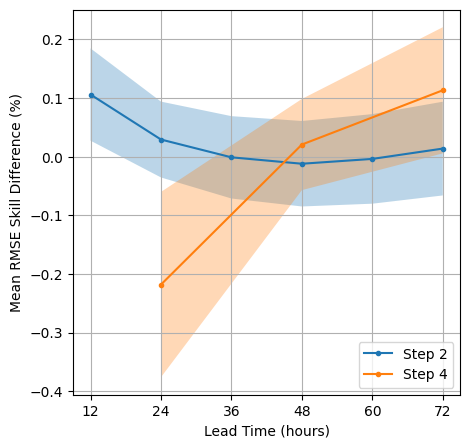

In [134]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

step_2_x = np.arange(mean_error_per_step.shape[0]) * 12 + 12
ax.plot(step_2_x, mean_error_per_step, ".-", label="Step 2")
ax.fill_between(step_2_x, mean_error_per_step - std_error_per_step, mean_error_per_step + std_error_per_step, alpha=0.3)

step_4_x = np.arange(mean_error_per_step_4.shape[0]) * 24 + 24
ax.plot(step_4_x, mean_error_per_step_4, ".-", label="Step 4")
ax.fill_between(step_4_x, mean_error_per_step_4 - std_error_per_step_4, mean_error_per_step_4 + std_error_per_step_4, alpha=0.3)

ax.set_xlabel("Lead Time (hours)")
ax.set_ylabel("Mean RMSE Skill Difference (%)")

ax.set_xticks(step_2_x)
ax.legend(loc="lower right")

ax.grid(True)

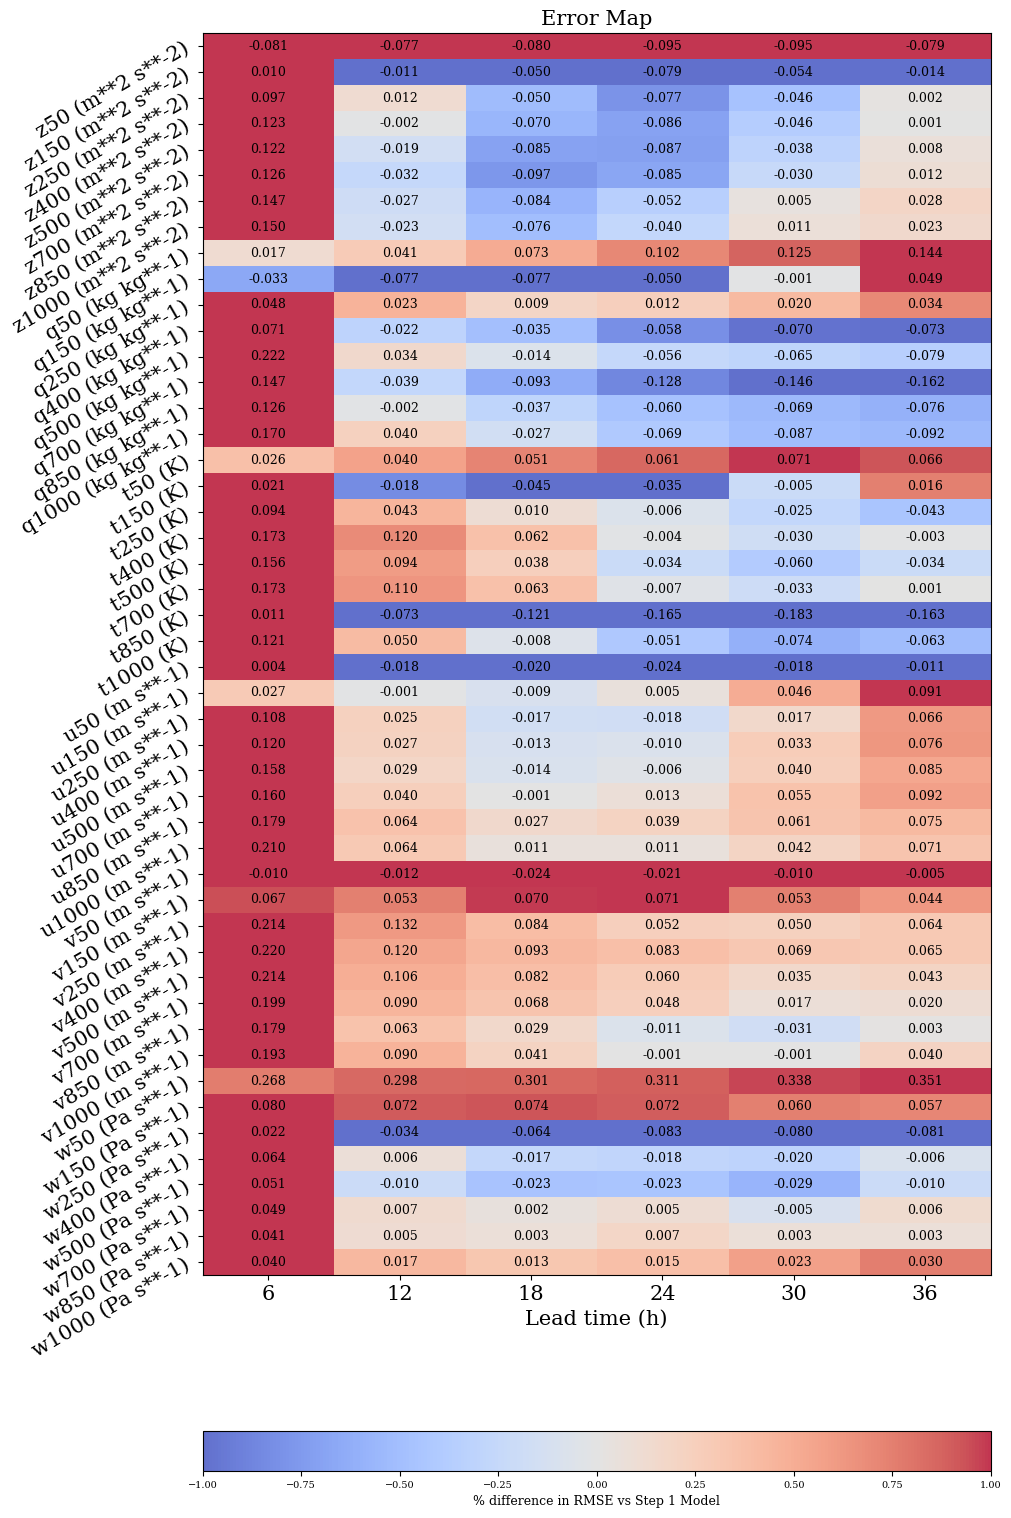

In [177]:
# Third-party
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# First-party
from neural_lam import constants, utils

@matplotlib.rc_context(utils.fractional_plot_bundle(1))
def plot_error_map(errors, dataset_constants, title=None, step_length=6, summary=False):
    """
    Plot a heatmap of errors of different variables at different
    predictions horizons
    errors: (pred_steps, d_f)
    """
    # errors_np = errors.T.cpu().numpy()  # (d_f, pred_steps)
    errors_np = errors
    var_subset = dataset_constants.HEAT_MAP_VARS if summary else range(errors_np.shape[0])
    errors_np = errors_np[var_subset, :]
    d_f, pred_steps = errors_np.shape

    # Normalize all errors to [0,1] for color map
    max_errors = errors_np.max(axis=1)  # d_f
    errors_norm = errors_np / np.expand_dims(max_errors, axis=1)

    fig, ax = plt.subplots(figsize=(10, 15))

    cax = ax.imshow(
        errors_norm,
        cmap=plt.get_cmap('coolwarm'),
        vmin=-1.0,
        vmax=1.0,
        interpolation="none",
        aspect="auto",
        alpha=0.8,
    )
    
    # Add color bar
    cbar = fig.colorbar(cax, ax=ax, orientation='horizontal')
    cbar.set_label('% difference in RMSE vs Step 1 Model')

    # ax and labels
    for (j, i), error in np.ndenumerate(errors_np):
        # Numbers > 9999 will be too large to fit
        formatted_error = f"{error:.3f}"
        ax.text(i, j, formatted_error, ha="center", va="center", usetex=False)

    # Ticks and labels
    label_size = 15
    ax.set_xticks(np.arange(pred_steps))
    pred_hor_i = np.arange(pred_steps) + 1  # Prediction horiz. in index
    pred_hor_h = step_length * pred_hor_i  # Prediction horiz. in hours
    ax.set_xticklabels(pred_hor_h, size=label_size)
    ax.set_xlabel("Lead time (h)", size=label_size)

    ax.set_yticks(np.arange(d_f))
    y_ticklabels = [
        f"{dataset_constants.PARAM_NAMES_SHORT[var_idx]} ({dataset_constants.PARAM_UNITS[var_idx]})"
        for var_idx in var_subset
    ]
    ax.set_yticklabels(y_ticklabels, rotation=30, size=label_size)

    if title:
        ax.set_title(title, size=15)

    return fig

fig = plot_error_map(step_2_vs_step_1, constants.ERA5UKConstants, title="Error Map", summary=False)

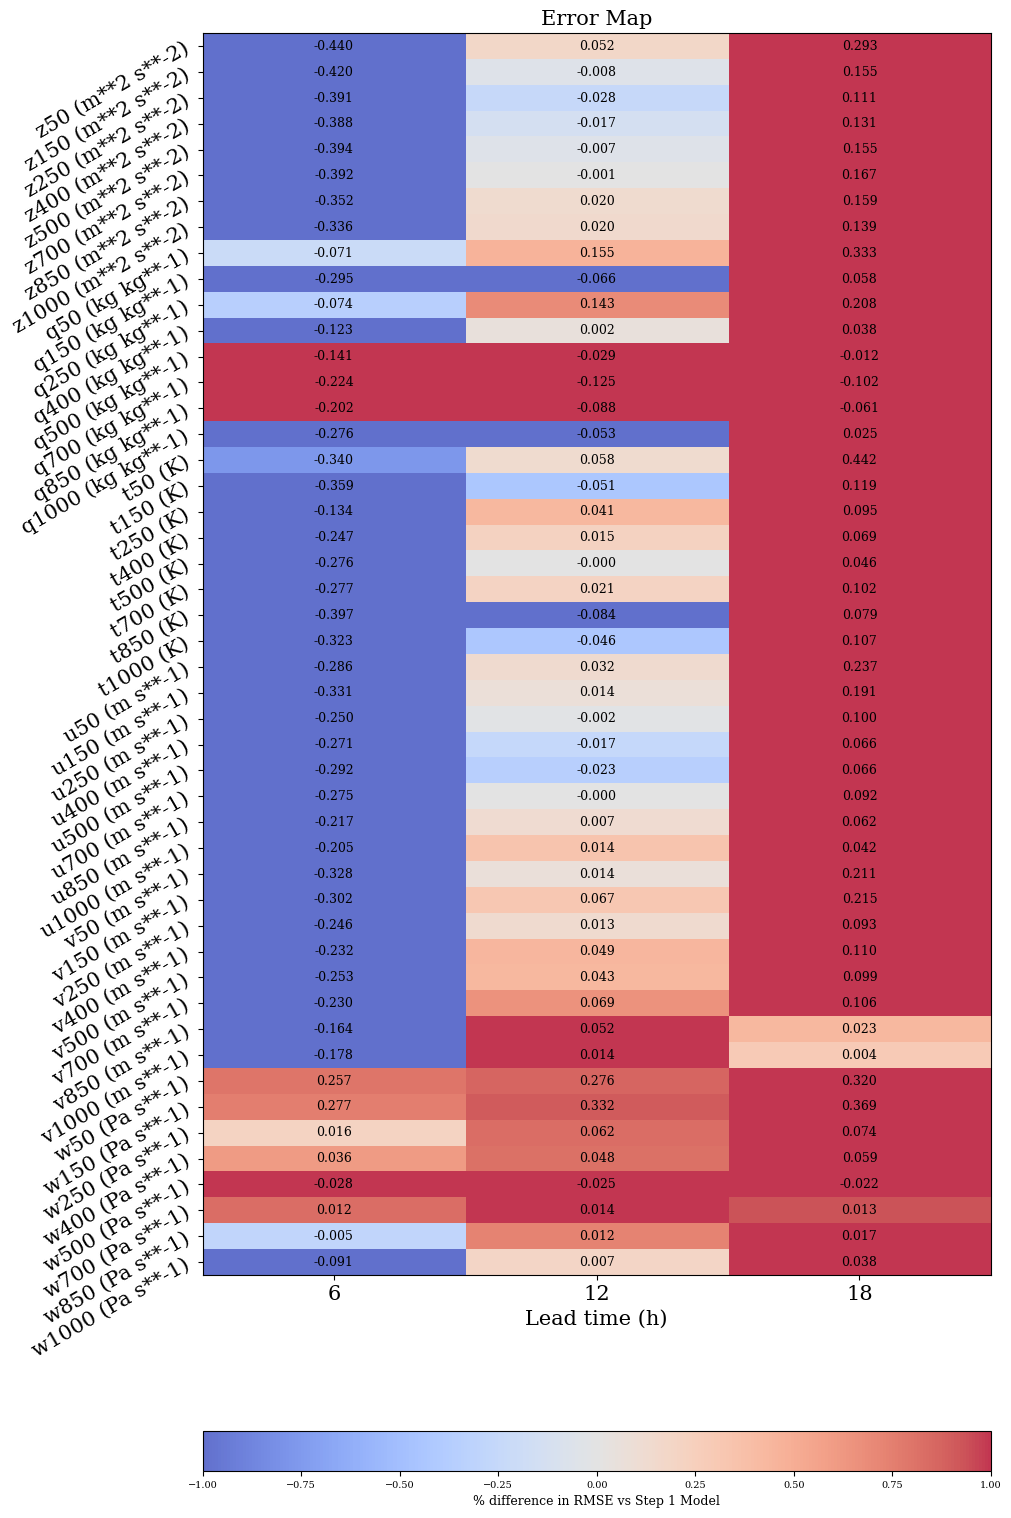

In [10]:
fig = plot_error_map(step_4_vs_step_1, constants.ERA5UKConstants, title="Error Map", summary=False)

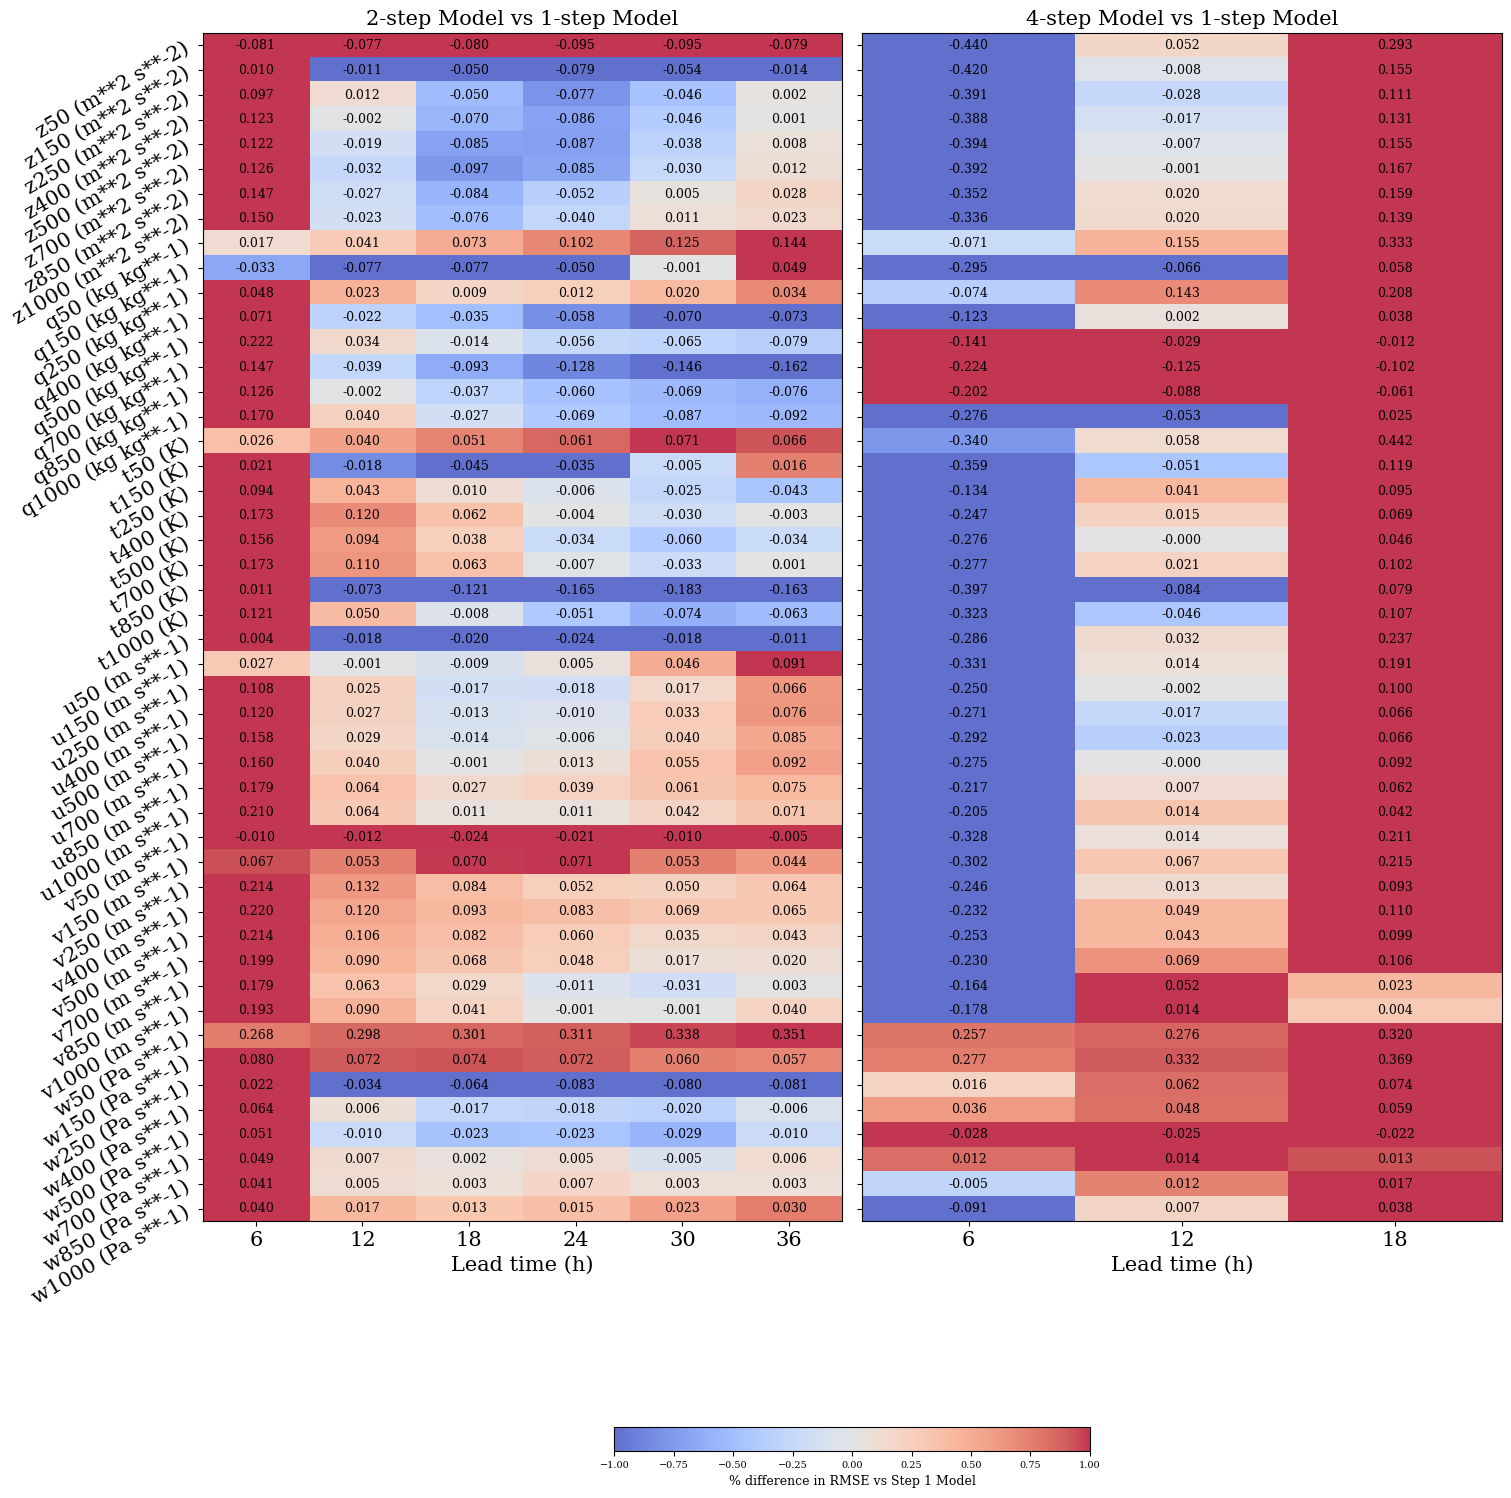

In [11]:
import matplotlib.pyplot as plt
import numpy as np

@matplotlib.rc_context(utils.fractional_plot_bundle(1))
def plot_error_maps(errors1, errors2, dataset_constants, title1=None, title2=None, step_length=6, summary=False):
    """
    Plot two heatmaps of errors of different variables at different prediction horizons side by side.
    errors1: (pred_steps, d_f) for the first heatmap
    errors2: (pred_steps, d_f) for the second heatmap
    """
    def normalize_errors(errors, var_subset):
        errors_np = errors[var_subset, :]
        max_errors = errors_np.max(axis=1)  # d_f
        errors_norm = errors_np / np.expand_dims(max_errors, axis=1)
        return errors_np, errors_norm

    var_subset = dataset_constants.HEAT_MAP_VARS if summary else range(errors1.shape[0])
    errors_np1, errors_norm1 = normalize_errors(errors1, var_subset)
    errors_np2, errors_norm2 = normalize_errors(errors2, var_subset)

    d_f, pred_steps1 = errors_np1.shape
    pred_steps2 = errors_np2.shape[1]

    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15, 15))

    cax1 = axes[0].imshow(
        errors_norm1,
        cmap=plt.get_cmap('coolwarm'),
        vmin=-1.0,
        vmax=1.0,
        interpolation="none",
        aspect="auto",
        alpha=0.8,
    )
    cax2 = axes[1].imshow(
        errors_norm2,
        cmap=plt.get_cmap('coolwarm'),
        vmin=-1.0,
        vmax=1.0,
        interpolation="none",
        aspect="auto",
        alpha=0.8,
    )

    # Add shared color bar
    cbar = fig.colorbar(cax1, ax=axes, orientation='horizontal', fraction=0.02, pad=0.1)
    cbar.set_label('% difference in RMSE vs Step 1 Model')

    label_size = 15

    for ax, errors_np, pred_steps, title in zip(axes, [errors_np1, errors_np2], [pred_steps1, pred_steps2], [title1, title2]):
        for (j, i), error in np.ndenumerate(errors_np):
            formatted_error = f"{error:.3f}"
            ax.text(i, j, formatted_error, ha="center", va="center", usetex=False)

        ax.set_xticks(np.arange(pred_steps))
        pred_hor_i = np.arange(pred_steps) + 1
        pred_hor_h = step_length * pred_hor_i
        ax.set_xticklabels(pred_hor_h, size=label_size)
        ax.set_xlabel("Lead time (h)", size=label_size)

        ax.set_yticks(np.arange(d_f))
        y_ticklabels = [
            f"{dataset_constants.PARAM_NAMES_SHORT[var_idx]} ({dataset_constants.PARAM_UNITS[var_idx]})"
            for var_idx in var_subset
        ]
        ax.set_yticklabels(y_ticklabels, rotation=30, size=label_size)

        if title:
            ax.set_title(title, size=15)

    # plt.tight_layout()
    return fig

# Example usage:
fig = plot_error_maps(step_2_vs_step_1, step_4_vs_step_1, ERA5UKConstants, title1='2-step Model vs 1-step Model', title2='4-step Model vs 1-step Model')
# plt.show()


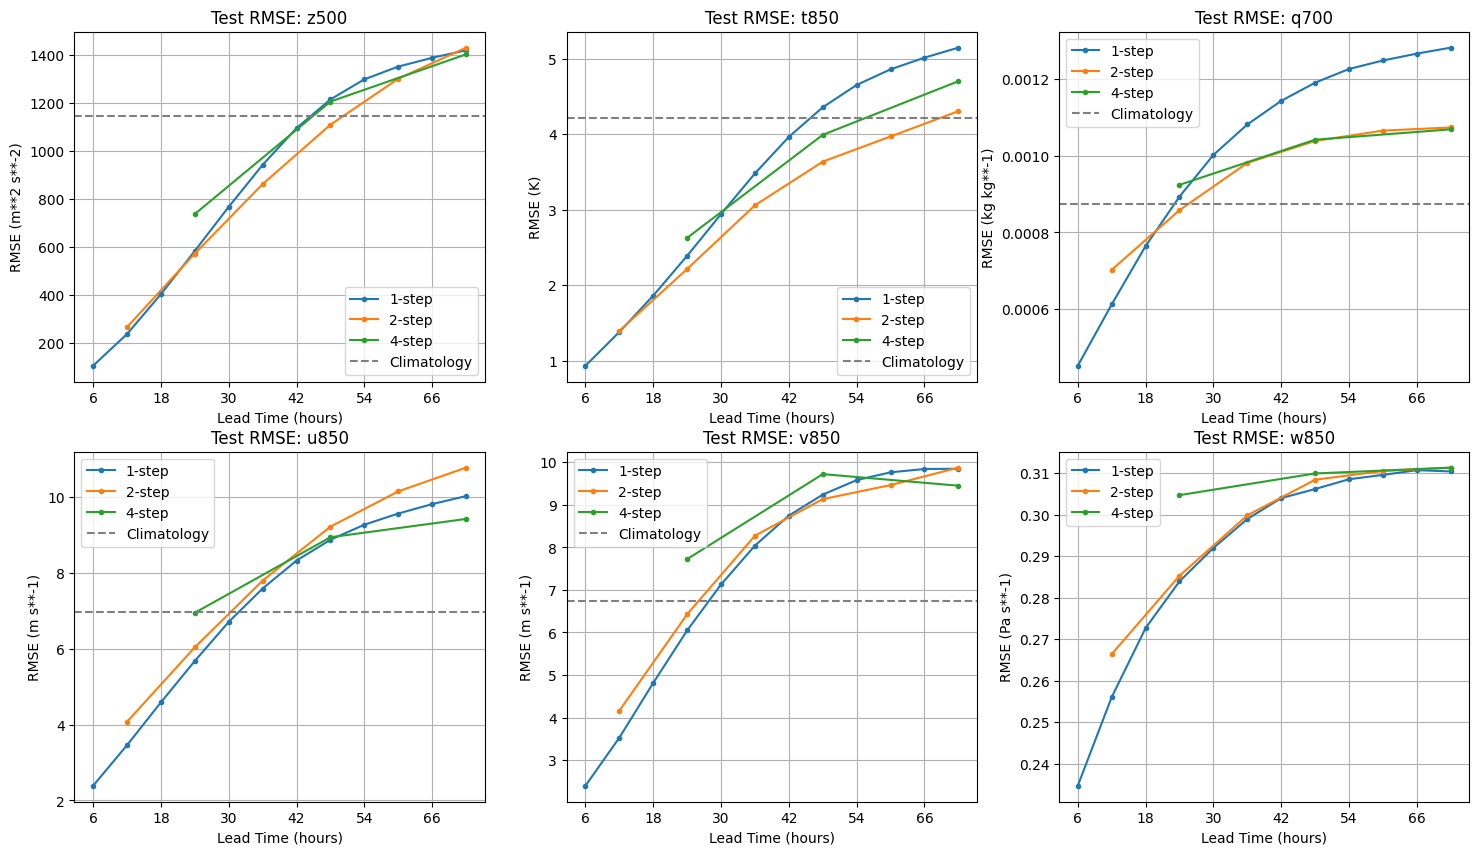

In [178]:
headline_vars = ["z500", "t850", "q700", "u850", "v850", "w850"]

def time_rollout_axs(
    ax, 
    var_name,
):
    var_idx = ERA5UKConstants.PARAM_NAMES.index(var_name)
    var_unit = ERA5UKConstants.PARAM_UNITS[var_idx]
    
    step_1_x = np.arange(step_1_rmse.shape[1])
    ax.plot(step_1_x, step_1_rmse[var_idx], ".-", label="1-step")
    
    step_2_x = (np.arange(step_2_rmse.shape[1])) * 2 + 1
    ax.plot(step_2_x, step_2_rmse[var_idx], ".-", label="2-step")
    
    step_4_x = (np.arange(step_4_rmse.shape[1])) * 4 + 3
    ax.plot(step_4_x, step_4_rmse[var_idx], ".-", label="4-step")
        

    if var_name in ERA5UKConstants.CLIMATOLOGY:
        var_clim = ERA5UKConstants.CLIMATOLOGY[var_name]
        ax.axhline(var_clim, color="grey", linestyle="--", label="Climatology")

    xticks_pos = range(0, step_1_rmse.shape[1], 2)
    xticks_labels = [str((tick + 1) * 6) for tick in xticks_pos]
    ax.set_xticks(xticks_pos)
    ax.set_xticklabels(xticks_labels)

    ax.legend()
    ax.set_xlabel("Lead Time (hours)")
    ax.set_ylabel(f"RMSE ({var_unit})")
    ax.set_title(f"Test RMSE: {var_name}")
    ax.grid(True)

fig, axs = plt.subplots(2, 3, figsize=(18, 10))
for ax, var_name in zip(axs.flat, headline_vars):
    time_rollout_axs(
        ax, 
        var_name,
    )
    

# Time Attention 

In [165]:
time_2_layer_norm_rmse = load_single_level_rmse("./wandb/offline-run-20240613_003416-pnyz944f")
score(time_2_layer_norm_rmse, step_1_rmse)
time_2_layer_norm_resid_rmse = load_single_level_rmse("./wandb/offline-run-20240613_003758-7i6qnjgt")
score(time_2_layer_norm_rmse, step_1_rmse)

time_2_layer_norm_attention_rmse = load_single_level_rmse("./wandb/offline-run-20240613_004107-624u80py")
score(time_2_layer_norm_attention_rmse, step_1_rmse)

time_2_layer_norm_mesh_residual_attention_rmse = load_single_level_rmse("./wandb/offline-run-20240613_004412-d80t39x5")
score(time_2_layer_norm_mesh_residual_attention_rmse, step_1_rmse)

time_3_rmse = load_single_level_rmse("./wandb/offline-run-20240613_004710-w4en2g4z")
score(time_3_rmse, step_1_rmse)

time_3_layer_norm_rmse = load_single_level_rmse("./wandb/offline-run-20240613_005012-8ydaj3hu")
score(time_3_layer_norm_rmse, step_1_rmse)


ValueError: operands could not be broadcast together with shapes (48,8) (48,12) 

In [ ]:
0.609375 0.10406049953550944
0.7465277777777778 0.11060343621256061


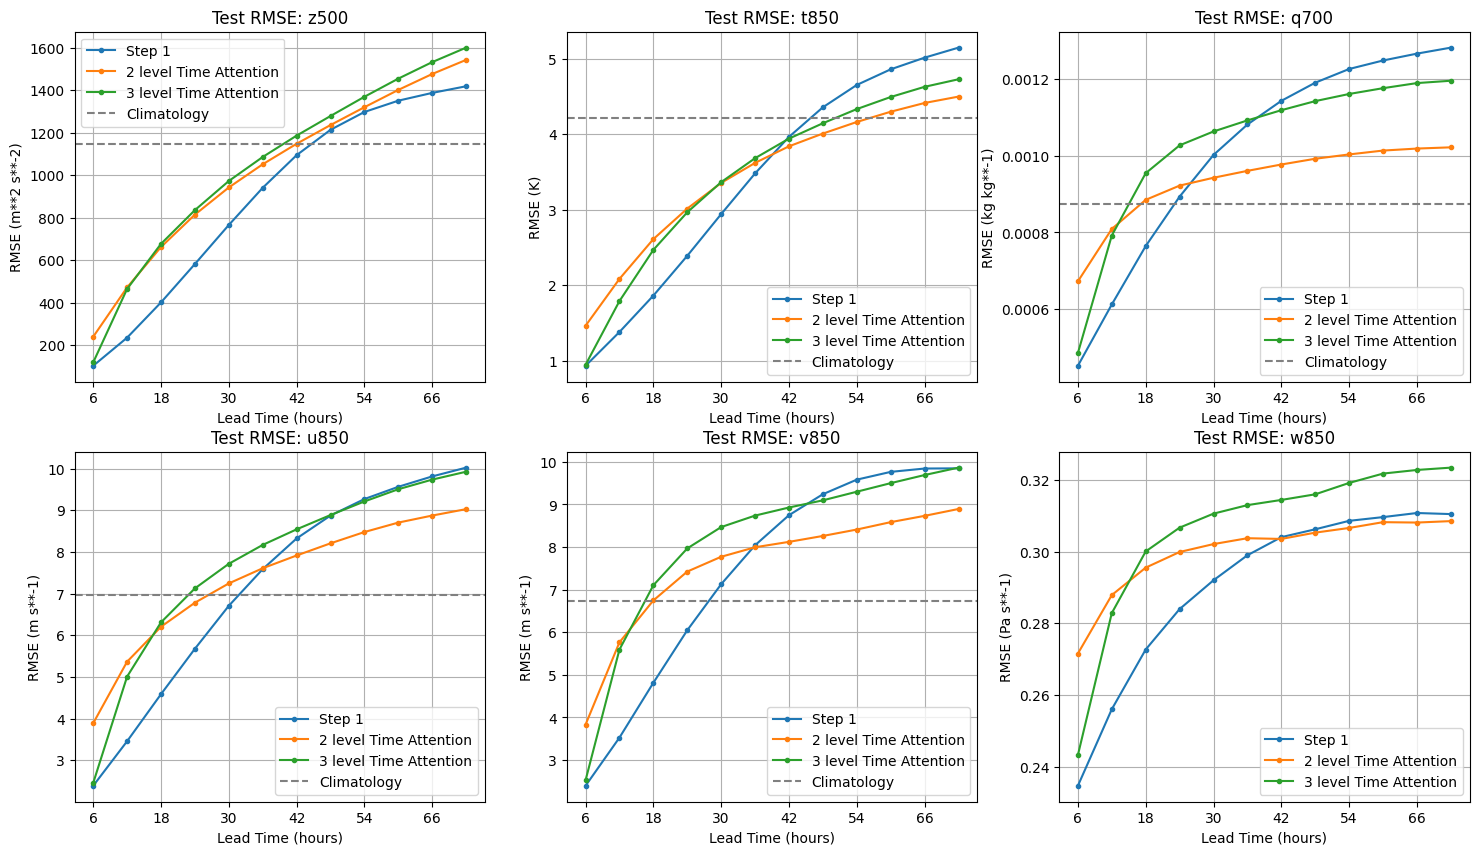

In [156]:
rmses = [
    step_1_rmse, 
    time_2_layer_norm_mesh_residual_attention_rmse,
    time_3_layer_norm_rmse
]
labels = [
    "Step 1",
    "2 level Time Attention",
    "3 level Time Attention"
]

headline_vars = ["z500", "t850", "q700", "u850", "v850", "w850"]

fig, axs = plt.subplots(2, 3, figsize=(18, 10))
for ax, var_name in zip(axs.flat, headline_vars):
    rollout_axs(
        ax, 
        var_name,
        rmses=rmses,
        labels=labels
    )

In [144]:
level2_error_per_time = (time_2_layer_norm_mesh_residual_attention_rmse - step_1_rmse) / step_1_rmse
mean_level2_error_per_time = np.mean(level2_error_per_time, axis=0)
std_level2_error_per_time = np.std(level2_error_per_time, axis=0)

level3_error_per_time = (time_3_layer_norm_rmse - step_1_rmse) / step_1_rmse
mean_level3_error_per_time = np.mean(level3_error_per_time, axis=0)
std_level3_error_per_time = np.std(level3_error_per_time, axis=0)

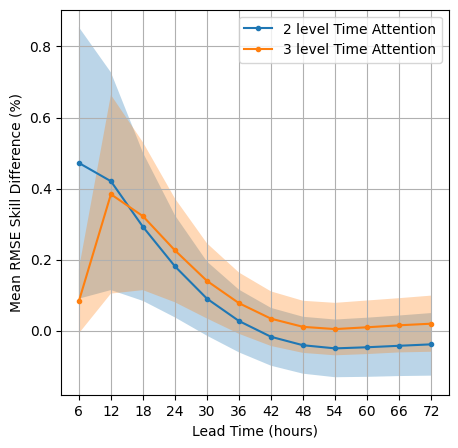

In [151]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

x = np.arange(mean_level2_error_per_time.shape[0]) * 6 + 6
ax.plot(x, mean_level2_error_per_time, ".-", label="2 level Time Attention")
ax.fill_between(x, mean_level2_error_per_time - std_level2_error_per_time, mean_level2_error_per_time + std_level2_error_per_time, alpha=0.3)

ax.plot(x, mean_level3_error_per_time, ".-", label="3 level Time Attention")
ax.fill_between(x, mean_level3_error_per_time - std_level3_error_per_time, mean_level3_error_per_time + std_level3_error_per_time, alpha=0.3)

ax.set_xlabel("Lead Time (hours)")
ax.set_ylabel("Mean RMSE Skill Difference (%)")

ax.set_xticks(x)
ax.legend(loc="upper right")

ax.grid(True)

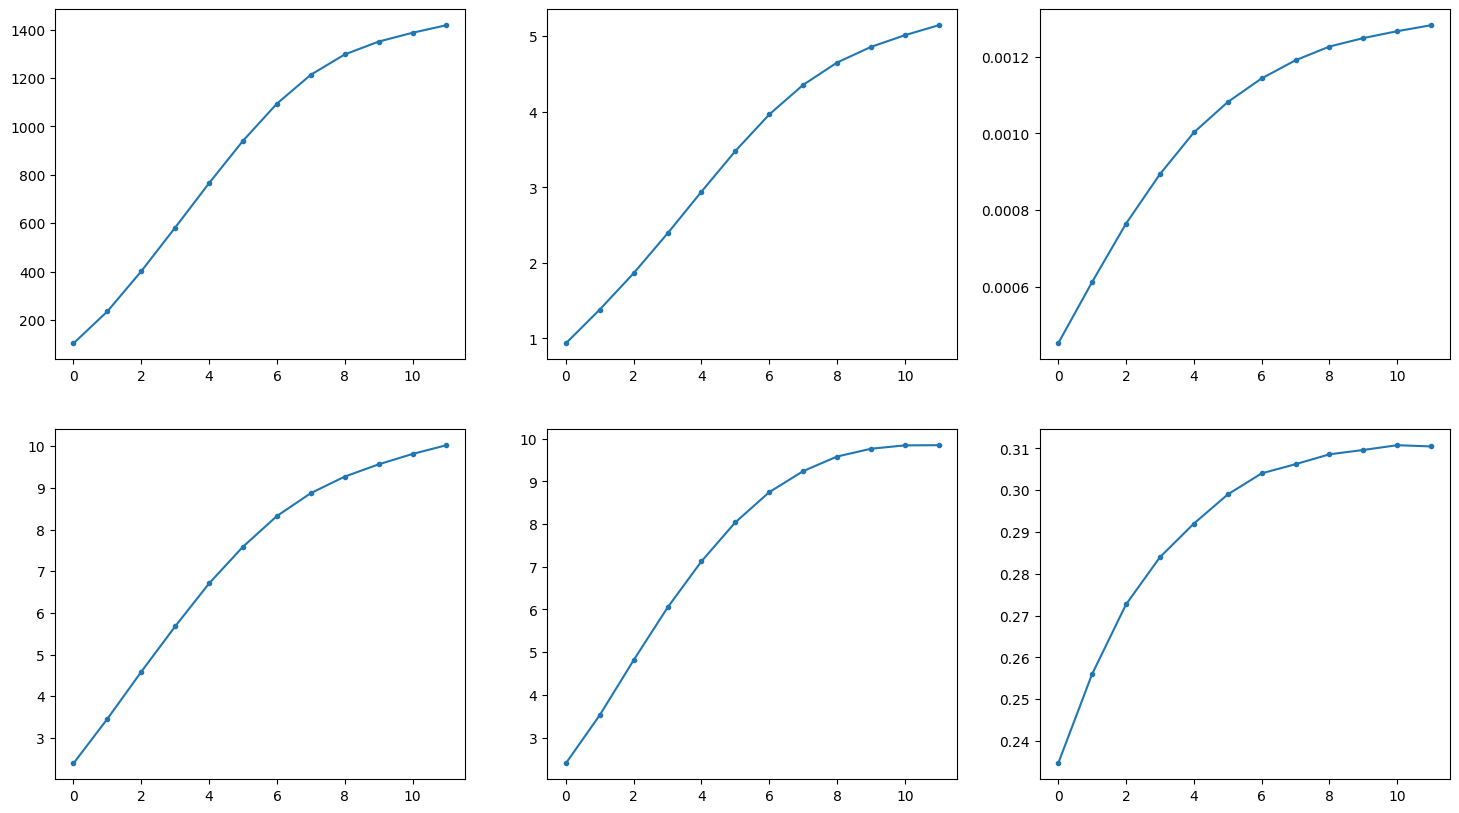

In [141]:
headline_vars = ["z500", "t850", "q700", "u850", "v850", "w850"]

def time_rollout_axs(
    ax, 
    var_name,
):
    var_idx = ERA5UKConstants.PARAM_NAMES.index(var_name)
    var_unit = ERA5UKConstants.PARAM_UNITS[var_idx]
    
    step_1_x = np.arange(step_1_rmse.shape[1])
    ax.plot(step_1_x, step_1_rmse[var_idx], ".-", label="1-step")
    

fig, axs = plt.subplots(2, 3, figsize=(18, 10))
for ax, var_name in zip(axs.flat, headline_vars):
    time_rollout_axs(
        ax, 
        var_name,
    )
    

# More Training Data is Better

## Setup Data

In [179]:
# uk max 
# graph_lam-4x64-06_07_02-4091
uk_max_local_rmse = load_single_level_rmse("./wandb/offline-run-20240611_184843-ap9kleim")
# uk_max_local_rmse_1 = load_single_level_rmse("./wandb/offline-run-20240611_015619-ixygkxie")

# uk big
# graph_lam-4x64-06_07_23-8758
uk_big_local_rmse = load_single_level_rmse("./wandb/offline-run-20240611_184044-1sq893rt")
# uk_big_local_rmse_1 = load_single_level_rmse("./wandb/offline-run-20240610_010047-bbjp9w1x")

uk_small_local_rmse = load_single_level_rmse("./wandb/offline-run-20240613_001441-oyn09fzz")

# Training on coarse graph, eval on small graph
train_coarse_test_big_rmse = load_single_level_rmse("./wandb/offline-run-20240611_211225-jio202fx")

# Training on coarse graph, eval on small graph
train_coarse_test_small_rmse = load_single_level_rmse("./wandb/offline-run-20240611_210434-d6pk07tw")

coarse_rmse = load_single_level_rmse("./wandb/offline-run-20240608_200314-j3hmhi2u")

# score(train_coarse_test_big_rmse, uk_big_local_rmse)
# score(train_coarse_test_small_rmse, uk_big_local_rmse)
score(uk_small_local_rmse, uk_max_local_rmse)
score(uk_big_local_rmse, uk_max_local_rmse)
score(uk_small_local_rmse, uk_big_local_rmse)

0.8463541666666666 0.17646126536301654
0.8307291666666666 0.08750800083895187
0.734375 0.08049433144296556


## Make Plot

0.8307291666666666 0.08750800083895187
0.8463541666666666 0.17646126536301654
0.6744791666666666 0.06260680511513865
0.19791666666666666 -0.02674596499406016


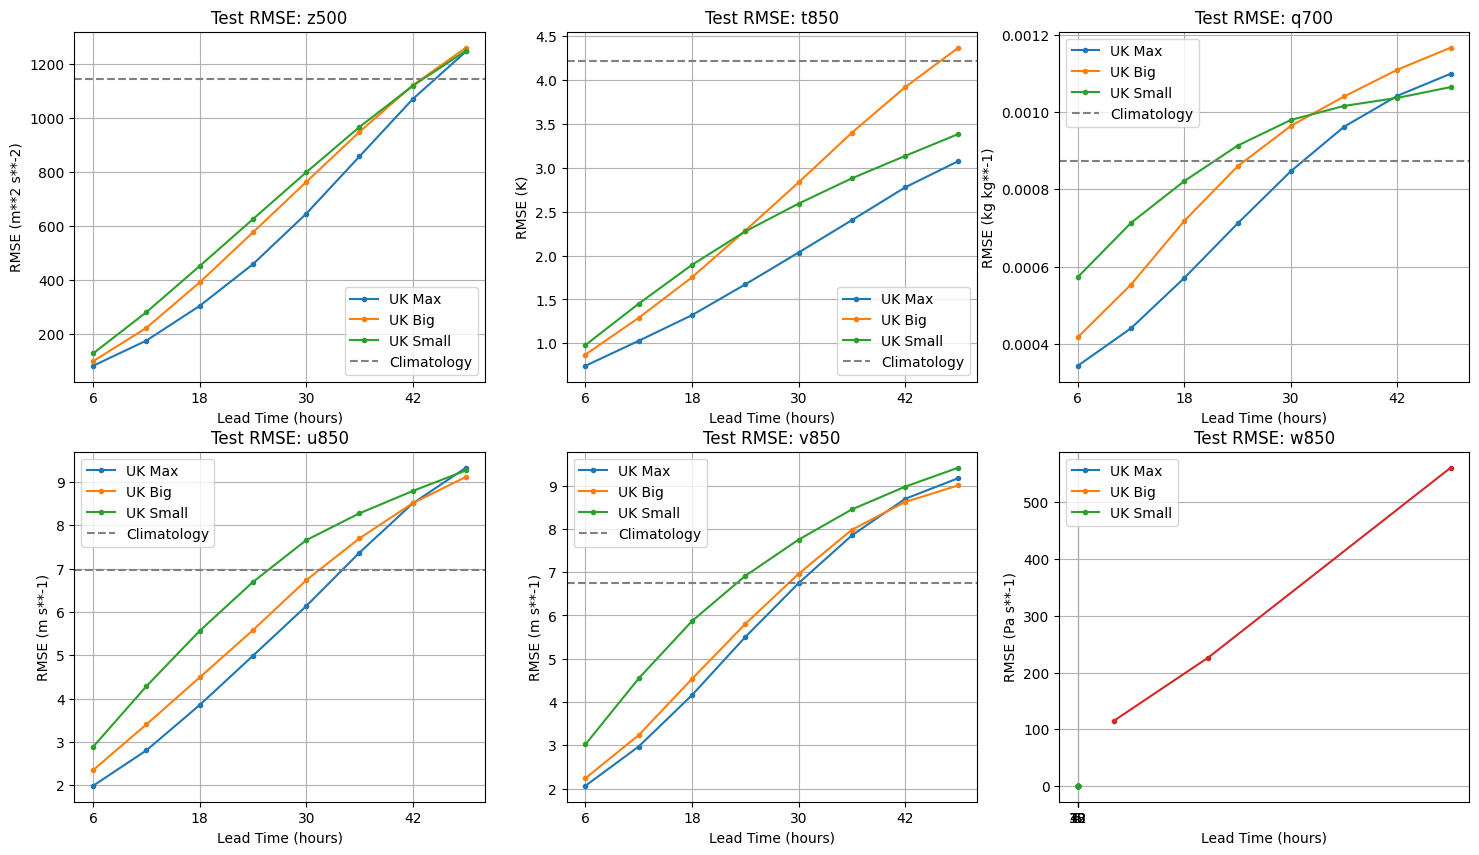

In [180]:
def num_grid_nodes(dataset):
    grid = np.load(f"../data/{dataset}/static/nwp_xy.npy")
    return grid.shape[1] * grid.shape[2]

times = np.array([115.381, 226.244, 561.162])
uk_small = num_grid_nodes("era5_uk_small")
uk_big = num_grid_nodes("era5_uk_big")
uk_max = num_grid_nodes("era5_uk_max")

grid_nodes = np.array([
    uk_small,
    uk_big,
    uk_max,
])

rmses = [
    uk_max_local_rmse, 
    uk_big_local_rmse,
    uk_small_local_rmse,
    # train_coarse_test_small_rmse,
    # train_coarse_test_big_rmse,
]
labels = [
    "UK Max",
    "UK Big",
    "UK Small",
    # "Train Coarse Big Test Small",
    # "Train Coarse Big Test Big",
]


headline_vars = ["z500", "t850", "q700",  "u850", "v850", "w850"]

fig, axs = plt.subplots(2, 3, figsize=(18, 10))
for ax, var_name in zip(axs.flat, headline_vars):
    rollout_axs(
        ax, 
        var_name,
        rmses=rmses,
        labels=labels
    )

ax.plot(grid_nodes, times, ".-")
score(uk_big_local_rmse, uk_max_local_rmse)
score(uk_small_local_rmse, uk_max_local_rmse)

score(train_coarse_test_big_rmse, uk_big_local_rmse)
score(uk_small_local_rmse, train_coarse_test_small_rmse)

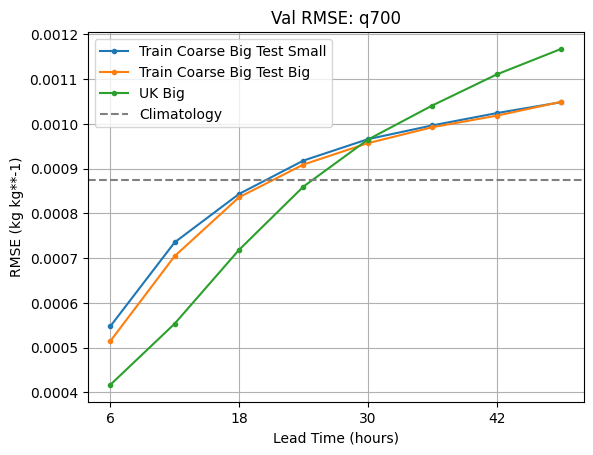

In [73]:
rmses = [
    train_coarse_test_small_rmse,
    train_coarse_test_big_rmse,
    uk_big_local_rmse,
    uk_small_local_rmse,
]
labels = [
    "Train Coarse Big Test Small",
    "Train Coarse Big Test Big",
    "UK Big",
    
]
fig, ax = plt.subplots()
rollout_axs(
    ax,
    "q700",
    rmses=rmses,
    labels=labels
)



# Space Resolution Results

In [181]:
uk_big_local_rmse.shape

(48, 8)

In [85]:
# Space Resolution V1 UK Small Train results
path = "./wandb/offline-run-20240610_022656-189fmoyz"
_, uk_small_train_level_1_rmse_test = load_space_attention_rmse(path, 8)
score(uk_small_train_level_1_rmse_test, uk_big_local_rmse)

path = "./wandb/offline-run-20240610_022856-1g5wx1zk"
_, uk_small_train_level_1_rmse_test_resid = load_space_attention_rmse(path, 8)
score(uk_small_train_level_1_rmse_test_resid, uk_big_local_rmse)

path = "./wandb/offline-run-20240610_022857-kvqeou88"
_, uk_small_train_level_1_rmse_test_att = load_space_attention_rmse(path, 8)
score(uk_small_train_level_1_rmse_test_att, uk_big_local_rmse)

path = "./wandb/offline-run-20240610_022857-wpgrdxu4"
_, uk_small_train_level_1_rmse_test_resid_att = load_space_attention_rmse(path, 8)
score(uk_small_train_level_1_rmse_test_resid_att, uk_big_local_rmse)

score(uk_big_local_rmse, uk_small_train_level_1_rmse_test_resid)


0.5182291666666666 -0.009396507683190879
0.3489583333333333 -0.028363596641130574
0.5651041666666666 0.01021645974179375
0.6796875 0.034183754348179336
0.6510416666666666 0.03387572455228526


In [172]:
path = "./wandb/offline-run-20240610_213742-1m39szm3"
_, uk_small_big_level_1_rmse_layer_norm = load_space_attention_rmse(path, 8)
score(uk_small_big_level_1_rmse_layer_norm, uk_big_local_rmse)

path = "./wandb/offline-run-20240610_214003-awzpj563"
_, uk_small_big_level_1_rmse_layer_norm_resid = load_space_attention_rmse(path, 8)
score(uk_small_big_level_1_rmse_layer_norm_resid, uk_big_local_rmse)

path = "./wandb/offline-run-20240610_214011-w3dgcdje"
_, uk_small_big_level_1_rmse_layer_norm_att = load_space_attention_rmse(path, 8)
score(uk_small_big_level_1_rmse_layer_norm_att, uk_big_local_rmse)

path = "./wandb/offline-run-20240610_214041-yjbcublz"
_, uk_small_big_level_1_rmse_layer_norm_resid_att = load_space_attention_rmse(path, 8)
score(uk_small_big_level_1_rmse_layer_norm_resid_att, uk_big_local_rmse)

0.8203125 0.04095454433622856
0.4947916666666667 0.007366018063378661
0.7083333333333334 0.026279795070468487
0.6875 0.01956255777494076


In [173]:
_, uk_small_big_v3_level_1_rmse = load_space_attention_rmse("./wandb/offline-run-20240611_181219-z89vpilc")
_, uk_small_big_v3_level_1_rmse_1 = load_space_attention_rmse("./wandb/offline-run-20240611_184511-cke3pfax")

score(uk_small_big_v3_level_1_rmse, uk_big_local_rmse)
score(uk_small_big_v3_level_1_rmse_1, uk_big_local_rmse)

ValueError: operands could not be broadcast together with shapes (48,12) (48,8) 

In [122]:
_, uk_small_max_level_1_rmse = load_space_attention_rmse("./wandb/offline-run-20240607_033537-ghutnlwk")
_, uk_small_max_v2_level_1_rmse = load_space_attention_rmse("./wandb/offline-run-20240607_033812-4uiaele1")

score(uk_small_max_level_1_rmse, uk_max_local_rmse)
score(uk_small_max_v2_level_1_rmse, uk_max_local_rmse)

0.6666666666666666 0.03134885237411237
0.6770833333333334 0.033545899848012685


In [88]:
score(uk_small_big_level_1_rmse_layer_norm, uk_max_local_rmse)

0.9010416666666666 0.1304904106997489


0.6666666666666666 0.03134885237411237
0.8619791666666666 0.12401606440577667


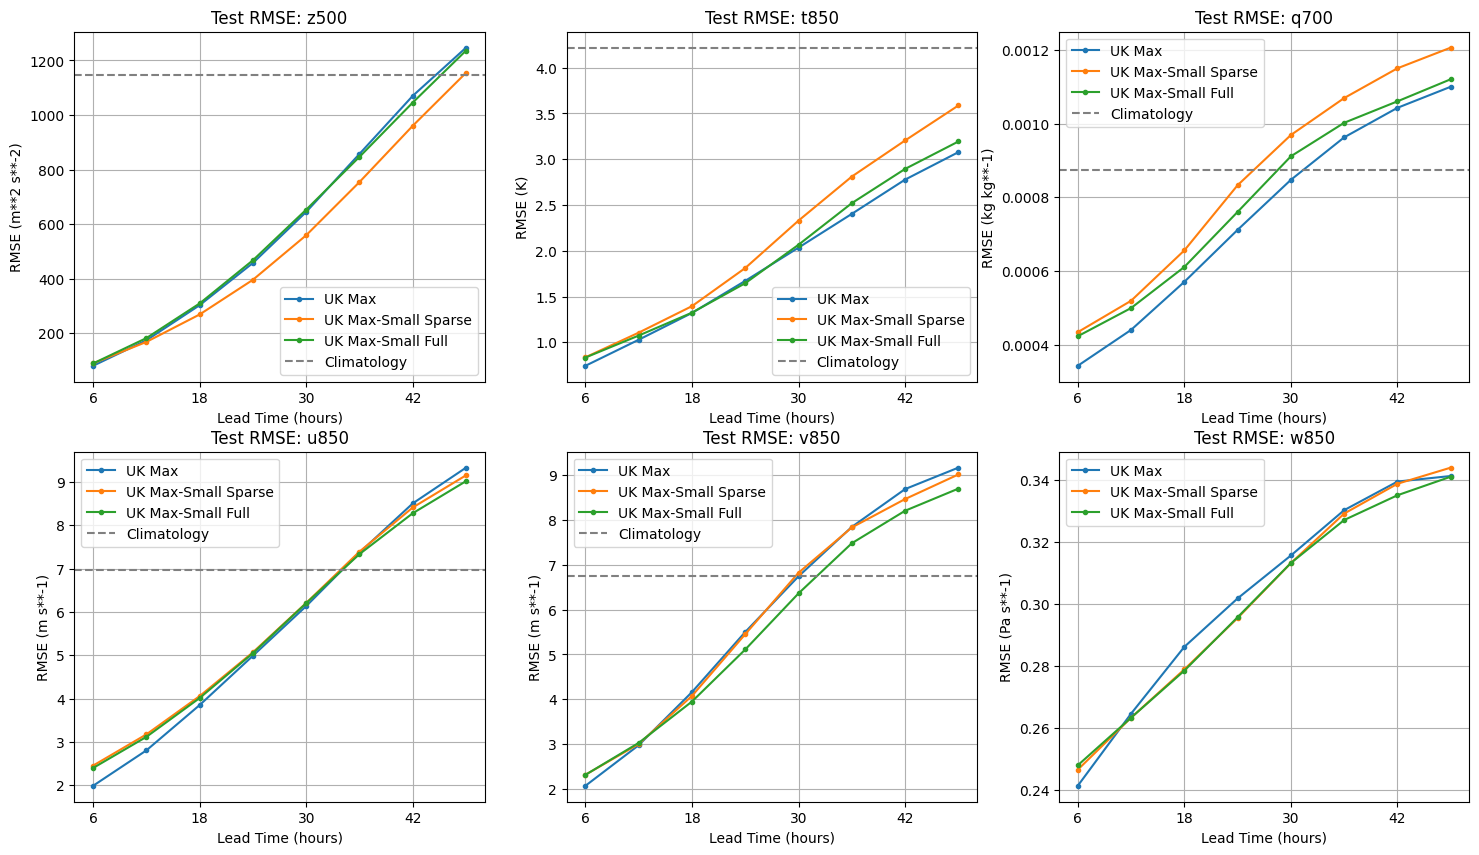

In [160]:
headline_vars = ["z500", "t850", "q700", "u850", "v850", "w850"]


fig, axs = plt.subplots(2, 3, figsize=(18, 10))
for ax, var_name in zip(axs.flat, headline_vars):
    rollout_axs(
        ax, 
        var_name,
        rmses=[
            # uk_big_local_rmse,
            # uk_small_train_level_1_rmse_test_resid,
            # uk_small_big_v3_level_1_rmse_1
            # uk_small_train_level_1_rmse_test,
            # uk_small_train_level_1_rmse_test_att,
            # uk_small_big_v3_level_1_rmse,
            uk_max_local_rmse,
            uk_small_max_level_1_rmse,
            uk_small_max_v2_level_1_rmse,
            # uk_small_train_level_1_rmse_test_resid_att,
        ],
        labels=[
            # "UK Big",
            # "UK Big-Small Sparse",
            # "UK Big-Small Full",
            # "UK Small",
            # "UK Small Att",
            # "UK Small Resid Att",
            # "UK Small Big V3",
            "UK Max",
            "UK Max-Small Sparse",
            "UK Max-Small Full",
        ]
    )

# score(uk_small_train_level_1_rmse_test_resid, uk_big_local_rmse)
# score(uk_small_big_v3_level_1_rmse, uk_big_local_rmse)

score(uk_small_max_level_1_rmse, uk_max_local_rmse)
score(uk_small_train_level_1_rmse_test_resid_att, uk_max_local_rmse)